Titanic is such a trategy and mystery. There are lots of theories and anecdotes about why "the ship that will never sink" actually sunk as well as who are the survivors VS non-survivors. It would be interesting to see how data analysis and machine learning algorithm can give us more insights on the characteristics and likelihood of survival of Titanic shipwreck. 

In this analysis I would like to focus on the following topics:
* Data processing and feature engineering
* Model training and selection
* Parameter/hyperparameter tuning for selected model

## 0.Load data and basic feature engineering
As the first step, let's load titanic train and test data and take a look at the data records.

In [2]:
dfTrain = pd.read_csv('/kaggle/input/titanic/train.csv')
dfTest = pd.read_csv('/kaggle/input/titanic/test.csv')
print(dfTrain.shape)
print(dfTest.shape)

(891, 12)
(418, 11)


In [3]:
print('There are {t} passengers in train data, of which {s} made it and {d} did not'.format(t = dfTrain.PassengerId.nunique(), s = dfTrain[dfTrain['Survived'] == 1].PassengerId.nunique(), d = dfTrain[dfTrain['Survived'] == 0].PassengerId.nunique()))

There are 891 passengers in train data, of which 342 made it and 549 did not


In [4]:
dfTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dfTest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 0.0 Describe train data and process missing values/outliers

In [6]:
print(dfTrain.columns)
dfTrain.describe()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some initial observations:
* From the statistics above there doesn't seem to be obvious outliers
* Pclass is taken as a numeric variable from the original dataset, but apparently it should be categorical. Let's turn it into a categorical variable

In [7]:
# Turn Pclass into a cateogrical variable
dfTrain['Pclass'] = dfTrain.Pclass.astype('category')

Next let's check for missing values and come up with strategies to fill them in.

In [8]:
# Show missing value counts by columns
dfTrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are three variables with missing values: Age, Cabin and Embarked. Here are my thoughts on strategies to handle missing values:
1. Age: since Pclass and Sex do not have missing values, we can calculate average age group by Pclass and Sex and fill in missing values accordingly
2. Cabin: this variable may indicate where the passenger's cabin room is in the ship, and may have an impact on survival rate. But since people could move around in the ship this variable may not contribute too much useful information, especially given the # of missing values. But let's take a look and see what we can find
3. Embarked: this should be related to Fare. We can take a look at Fare range for each existing Embarked variable and decide which Embarked value should be given the Fare

In [9]:
dfTrain.groupby(['Sex', 'Pclass']).agg({'Age': ['mean', 'median', 'min', 'max']}).reset_index()

Sex Pclass        Age                   
                       mean median   min   max
0  female      1  34.611765   35.0  2.00  63.0
1  female      2  28.722973   28.0  2.00  57.0
2  female      3  21.750000   21.5  0.75  63.0
3    male      1  41.281386   40.0  0.92  80.0
4    male      2  30.740707   30.0  0.67  70.0
5    male      3  26.507589   25.0  0.42  74.0

In [10]:
# assign passengers with missing age the average age of gender and class
avgAge = dfTrain.groupby(['Sex', 'Pclass']).Age.mean().reset_index()
dfTrain = dfTrain.merge(avgAge, 'left', on = ['Sex', 'Pclass'], suffixes = ('_orig', '_avg'))
dfTrain.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age_orig,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_avg
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,26.507589
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,34.611765
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21.750000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,34.611765
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,26.507589


In [11]:
# Fill in average age if original age value is NaN
def fill_in_avg_age(row):
    if np.isnan(row['Age_orig']):
        return row['Age_avg']
    else:
        return row['Age_orig']

dfTrain['Age'] = dfTrain.apply(lambda row: fill_in_avg_age(row), axis = 1) 

In [12]:
# Double check if things are filled in correctly
dfTrain[dfTrain.Age_orig.isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age_orig,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_avg,Age
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,26.507589,26.507589
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,30.740707,30.740707
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,21.750000,21.750000
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,26.507589,26.507589
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,21.750000,21.750000


Next let's examine Cabin. It seems that Cabin assignment may be related to Pclass so we can also take a look at missing values by Pclass.

In [13]:
print(dfTrain.Cabin.unique())
print('There are {n} different unique Cabin values'.format(n = dfTrain.Cabin.nunique()))
dfTrain[dfTrain.Cabin.isnull()].groupby('Pclass').PassengerId.nunique()

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148']
There are 147 different unique Cabin values

Pclass
1     40
2    168
3    479
Name: PassengerId, dtype: int64

There are 147 different values of Cabin, and they are in the format of 'X00'. Also the upper class tickets have much less missing values for Cabin, indicating that upper class passengers have an assigned room on the ship while lower class passengers may not (just standby?). We can extract the first letter of Cabin variable and find out.

In [14]:
# Fill unknown Cabin with 'U'
dfTrain.loc[dfTrain.Cabin.isnull(), 'Cabin'] = 'U'

# extract first letter of Cabin to indicate location on the ship
dfTrain['CabinLoc'] = dfTrain['Cabin'].str[0]

# assign an indicator to show if the passenger has Cabin assignment or not
def assign_cabin_ind(row):
    if row['Cabin'] == 'U':
        return 0
    else:
        return 1

dfTrain['CabinInd'] = dfTrain.apply(lambda x: assign_cabin_ind(x), axis = 1).astype('category')

In [15]:
print(dfTrain.groupby('CabinLoc').PassengerId.nunique().reset_index())
print(dfTrain.groupby(['Pclass', 'CabinInd']).PassengerId.nunique().reset_index())
print(dfTrain.groupby(['Pclass', 'CabinInd']).agg({'PassengerId': 'count', 'Fare': 'mean'}).reset_index())

  CabinLoc  PassengerId
0        A           15
1        B           47
2        C           59
3        D           33
4        E           32
5        F           13
6        G            4
7        T            1
8        U          687
  Pclass CabinInd  PassengerId
0      1        0           40
1      1        1          176
2      2        0          168
3      2        1           16
4      3        0          479
5      3        1           12
  Pclass CabinInd  PassengerId       Fare
0      1        0           40  76.848643
1      1        1          176  85.815152
2      2        0          168  20.909673
3      2        1           16  18.063544
4      3        0          479  13.725077
5      3        1           12  11.698608


In [16]:
dfTrain['CabinInd'] = dfTrain['CabinInd'].astype('category')

Next let's find out missing Embarked from fare range. I'm going to examine the range of Fare for each embarkment port and use 15th and 85th percentile as lower and higher ends. For passengers missing the port, if their Fare price falls within the range for a port, the port will be assigned to them. The order of assignment will be C, S, Q.

In [17]:
# assign embark based on people's fare
dfTrain.groupby(['Embarked']).agg({'Fare': ['min', 'mean', 'max']}).reset_index()

Embarked    Fare                     
               min       mean       max
0        C  4.0125  59.954144  512.3292
1        Q  6.7500  13.276030   90.0000
2        S  0.0000  27.079812  263.0000

In [18]:
dfTrain['CLow'] = dfTrain[dfTrain['Embarked'] == 'C'].Fare.quantile(0.15)
dfTrain['CHigh'] = dfTrain[dfTrain['Embarked'] == 'C'].Fare.quantile(0.85)
dfTrain['QLow'] = dfTrain[dfTrain['Embarked'] == 'Q'].Fare.quantile(0.15)
dfTrain['QHigh'] = dfTrain[dfTrain['Embarked'] == 'Q'].Fare.quantile(0.85)
dfTrain['SLow'] = dfTrain[dfTrain['Embarked'] == 'S'].Fare.quantile(0.15)
dfTrain['SHigh'] = dfTrain[dfTrain['Embarked'] == 'S'].Fare.quantile(0.85)

In [19]:
dfTrain.loc[dfTrain.Embarked.isnull(), 'Embarked'] = 'U'

In [20]:
def assign_missing_embarked(row):
    if row['Embarked'] != 'U':
        return row['Embarked']
    else:
        if row['Fare'] <= row['CHigh'] and row['Fare'] >= row['CLow']:
            return 'C'
        elif row['Fare'] <= row['SHigh'] and row['Fare'] >= row['SLow']:
            return 'S'
        elif row['Fare'] <= row['QHigh'] and row['Fare'] >= row['QLow']:
            return 'Q'
        else:
            return 'U'

dfTrain['Embarked_clean'] = dfTrain.apply(lambda x: assign_missing_embarked(x), axis = 1)

In [21]:
dfTrain.loc[dfTrain['Embarked'] == 'U', ['Embarked', 'Embarked_clean']]

,Embarked,Embarked_clean
61,U,C
829,U,C


Now that we have examined and cleaned up the data, let's take a look of columns and keep/rename of those we want to keep.

In [22]:
dfTrain = dfTrain.drop(columns = ['Age_orig', 'Embarked', 'Age_avg', 'Cabin', 'CLow', 'CHigh', 'QLow', 'QHigh', 'SLow', 'SHigh'])
dfTrain = dfTrain.rename(columns = {'Embarked_clean': 'Embarked'})
print(dfTrain.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Age', 'CabinLoc', 'CabinInd', 'Embarked'],
      dtype='object')


In [23]:
print(dfTrain.isnull().sum())
print(dfTrain.shape)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Age            0
CabinLoc       0
CabinInd       0
Embarked       0
dtype: int64
(891, 13)


### 0.1 More featuring engineering
There are two variables that may give out more information about the passegners: Name and Ticket.
Let's look at ticket first. Ideally the ticket information may tell you important information such as where the passenger boarded/unboarded and the starting port and destination port, etc. But unfortunately this time I don't have enough knowledge to know the coding of ticket numbers for this data set so won't be able to find out pattern (although I did notice a 'Paris' in one ticket number) so I'll pass this one for now. 

As for Name variable, I noticed I can extract title from the names, and for married women their own names and husbands' names, so maybe it is possible to know more detailed background of passengers (like if they are noble, military officers, religion/academic professionals or civilians).

In [24]:
# code to extract titles from names
def extract_title(row):
    return row['Name'].split(',')[1].split('.')[0].strip()

dfTrain['title'] = dfTrain.apply(lambda x: extract_title(x), axis = 1)

In [25]:
dfTrain.groupby('title').PassengerId.nunique()

title
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
Name: PassengerId, dtype: int64

In [26]:
# categorize titles into Military, Religion, Noble and Civilian
def categorize_titles(row):
    if row['title'] in ['Capt', 'Col', 'Major']:
        return 'Military'
    elif row['title'] in ['Rev', 'Dr']:
        return 'Religion'
    elif row['title'] in ['Don', 'Dona', 'Jonkheer', 'Lady', 'Master', 'Sir', 'the Countess']:
        return 'Noble'
    else:
        return 'Civilian'

dfTrain['TitleCate'] = dfTrain.apply(lambda x: categorize_titles(x), axis = 1)

In [27]:
dfTrain.groupby('TitleCate').PassengerId.count()

TitleCate
Civilian    828
Military      5
Noble        45
Religion     13
Name: PassengerId, dtype: int64

From the Name it is also possible to extract names of husbands from married female passengers (Mrs's) and check male passengers in a pool of married gentlemen to indicate if the husband is onboard with the wife. 

In [28]:
import re
def extract_names(row):
    if row['title'] in ['Mrs', 'the Countess']:
        s = row['Name'].split(',')[1]
        return re.sub('^.*\((.*?)\)[^\(]*$', '\g<1>', s)
    else:
        return row['Name'].split(',')[1].split('.')[1].strip() + ' ' + row['Name'].split(',')[0]
        

dfTrain['RealName'] = dfTrain.apply(lambda x: extract_names(x), axis = 1)

In [29]:
dfTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Age,CabinLoc,CabinInd,Embarked,title,TitleCate,RealName
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,22.0,U,0,S,Mr,Civilian,Owen Harris Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,38.0,C,1,C,Mrs,Civilian,Florence Briggs Thayer
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,26.0,U,0,S,Miss,Civilian,Laina Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,35.0,C,1,S,Mrs,Civilian,Lily May Peel
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,35.0,U,0,S,Mr,Civilian,William Henry Allen


In [30]:
# for Mrs's, extract their husbands name and create a list of husband names
def extract_husband_name(row):
    if row['title'] == 'Mrs':
        return row['Name'].split(',')[1].split('.')[1].split('(')[0].strip() + ' ' + row['Name'].split(',')[0].strip()
    else:
        return 'Unknown'
    
dfTrain['HusbandName'] = dfTrain.apply(lambda x: extract_husband_name(x), axis = 1)

In [31]:
husband_list = dfTrain[dfTrain['HusbandName'] != 'Unknown'].HusbandName.tolist()
name_list = dfTrain['RealName'].tolist()

In [32]:
dfTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Age,CabinLoc,CabinInd,Embarked,title,TitleCate,RealName,HusbandName
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,22.0,U,0,S,Mr,Civilian,Owen Harris Braund,Unknown
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,38.0,C,1,C,Mrs,Civilian,Florence Briggs Thayer,John Bradley Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,26.0,U,0,S,Miss,Civilian,Laina Heikkinen,Unknown
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,35.0,C,1,S,Mrs,Civilian,Lily May Peel,Jacques Heath Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,35.0,U,0,S,Mr,Civilian,William Henry Allen,Unknown


In [33]:

def assign_couple_onboard_ind(row):
    if row['title'] == 'Mrs':
        if row['HusbandName'] in name_list:
            return 1
        else:
            return 0
    else:
        if row['RealName'] in husband_list:
            return 1
        else:
            return 0

dfTrain['CoupleOnboardInd'] = dfTrain.apply(lambda x: assign_couple_onboard_ind(x), axis = 1)

In [34]:
dfTrain['CoupleOnboardInd'] = dfTrain['CoupleOnboardInd'].astype('category')

In [35]:
dfTrain.groupby(['CoupleOnboardInd']).PassengerId.count()

CoupleOnboardInd
0    807
1     84
Name: PassengerId, dtype: int64

In [36]:
dfTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Age,CabinLoc,CabinInd,Embarked,title,TitleCate,RealName,HusbandName,CoupleOnboardInd
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,22.0,U,0,S,Mr,Civilian,Owen Harris Braund,Unknown,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,38.0,C,1,C,Mrs,Civilian,Florence Briggs Thayer,John Bradley Cumings,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,26.0,U,0,S,Miss,Civilian,Laina Heikkinen,Unknown,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,35.0,C,1,S,Mrs,Civilian,Lily May Peel,Jacques Heath Futrelle,1
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,35.0,U,0,S,Mr,Civilian,William Henry Allen,Unknown,0


In summary, after more feature engineering, I can add three more variables to the original data set: CabinLoc, CabinInd, title, TitleCate and CoupleOnboardInd. I want to drop name related variables and Ticket because I don't think they could help with further EDA and modeling/scoring. The final data set looks like below:

In [37]:
dfTrain = dfTrain.drop(columns = ['Name', 'RealName', 'HusbandName', 'Ticket'])

SibSp and Parch can determine # travel companions and family size

In [38]:
dfTrain['TravelCompanionSize'] = dfTrain['SibSp'] + dfTrain['Parch']
def travel_companions(row):
    if row['TravelCompanionSize'] == 0:
        return 'Single Traveler'
    elif row['TravelCompanionSize'] <= 4:
        return 'Small Travel Group'
    else:
        return 'Big Travel Group'

def family_size(row):
    if row['Parch'] == 0:
        return 'Not with family'
    elif row['Parch'] <= 4:
        return 'Small family'
    else:
        return 'Big family'

dfTrain['TravelType'] = dfTrain.apply(lambda x: travel_companions(x), axis = 1)
dfTrain['FamilySize'] = dfTrain.apply(lambda x: family_size(x), axis = 1)

In [39]:
dfTrain.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Age,CabinLoc,CabinInd,Embarked,title,TitleCate,CoupleOnboardInd,TravelCompanionSize,TravelType,FamilySize
0,1,0,3,male,1,0,7.2500,22.0,U,0,S,Mr,Civilian,0,1,Small Travel Group,Not with family
1,2,1,1,female,1,0,71.2833,38.0,C,1,C,Mrs,Civilian,0,1,Small Travel Group,Not with family
2,3,1,3,female,0,0,7.9250,26.0,U,0,S,Miss,Civilian,0,0,Single Traveler,Not with family
3,4,1,1,female,1,0,53.1000,35.0,C,1,S,Mrs,Civilian,1,1,Small Travel Group,Not with family
4,5,0,3,male,0,0,8.0500,35.0,U,0,S,Mr,Civilian,0,0,Single Traveler,Not with family


## 1. More EDA and visualization

Now that I have the model-ready data set, I would like to create some visualizations to further look at details of the data. There are two topics I'm interested:
* General profiles of passengers
* Characteristics of survivors vs non-survivors

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

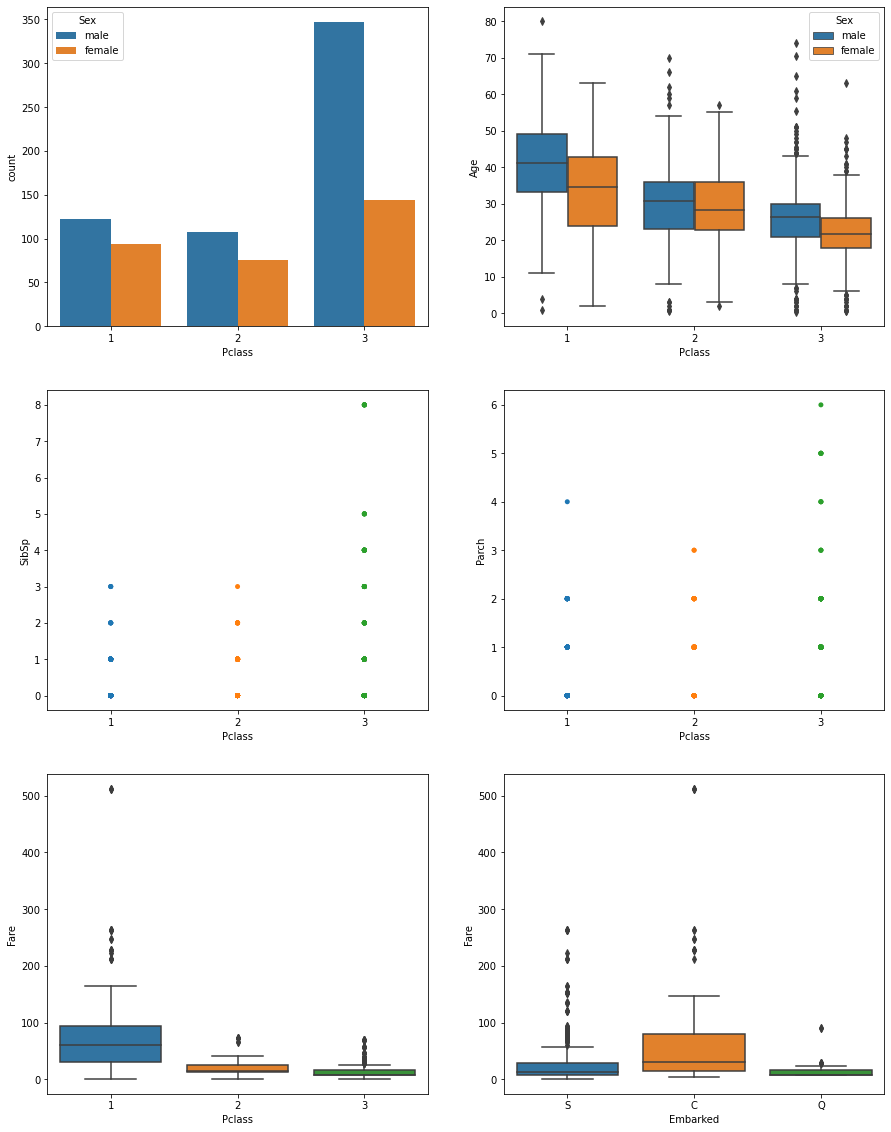

In [41]:
f, axes = plt.subplots(3, 2, figsize = (15, 20))
sns.countplot(x = 'Pclass', hue = 'Sex', data = dfTrain, ax = axes[0, 0])
sns.boxplot(x = "Pclass", y = "Age", hue = "Sex", data = dfTrain, ax = axes[0, 1])
sns.stripplot(x = 'Pclass', y = 'SibSp', jitter = False, data = dfTrain, ax = axes[1, 0])
sns.stripplot(x = 'Pclass', y = 'Parch', jitter = False, data = dfTrain, ax = axes[1, 1])
sns.boxplot(x = 'Pclass', y = 'Fare', data = dfTrain, ax = axes[2, 0])
sns.boxplot(x = 'Embarked', y = 'Fare', data = dfTrain, ax = axes[2, 1])
f.show()

In general, there are more male and lower class passengers. Upper class passengers tend to be older and have smaller family size/less travel companions.

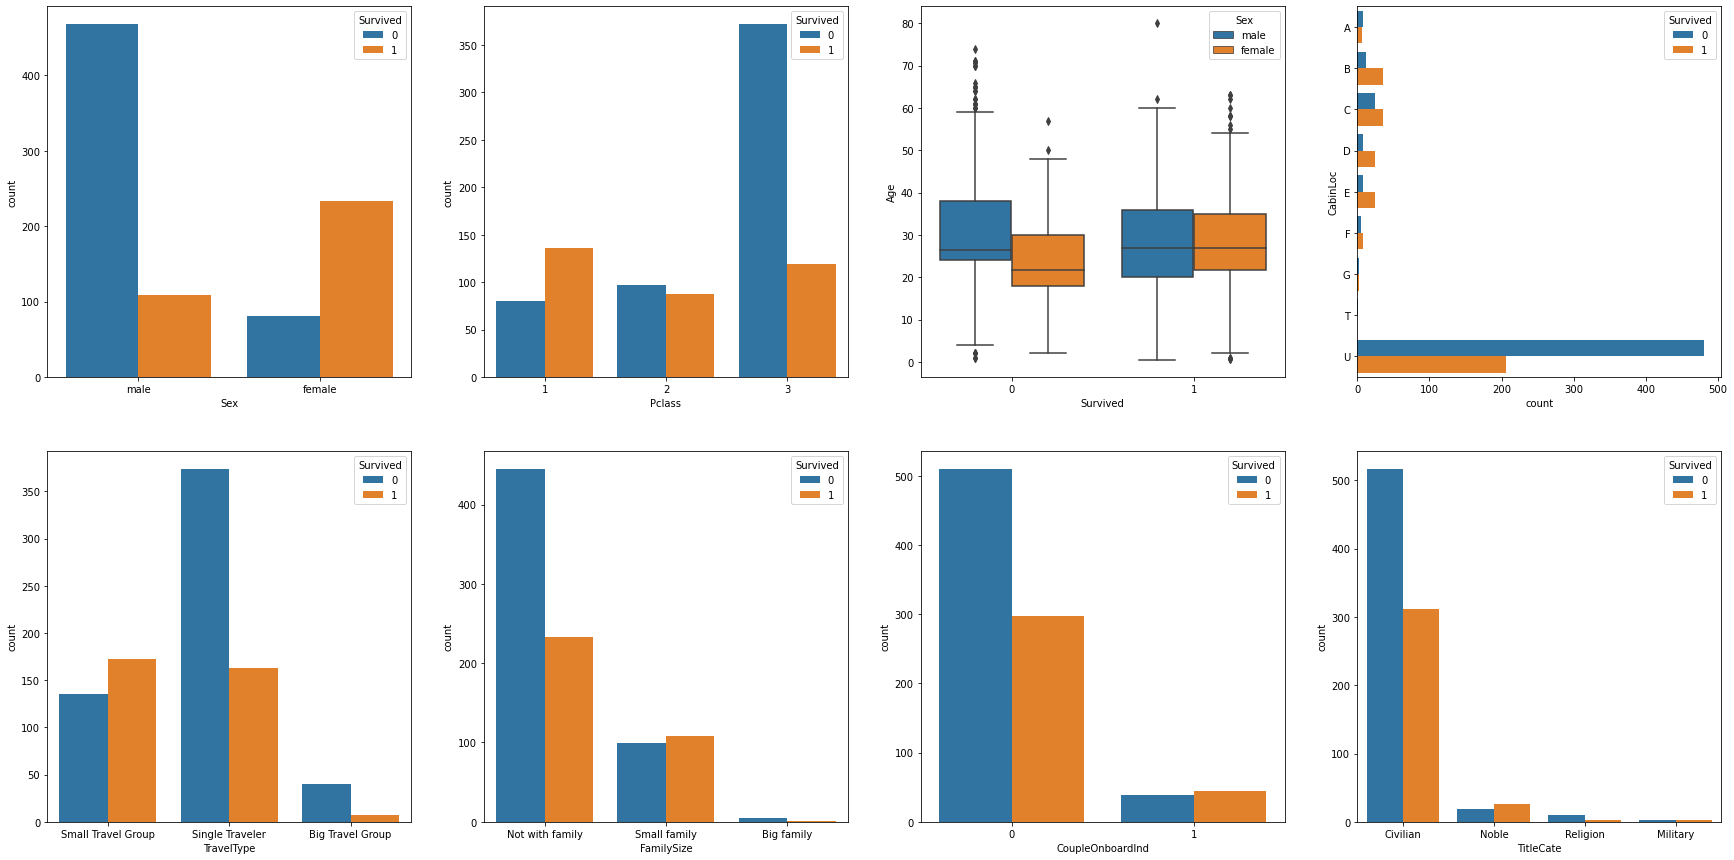

In [42]:
f, axes = plt.subplots(2, 4, figsize = (30, 15))
sns.countplot(x = 'Sex', hue = 'Survived', data = dfTrain, ax = axes[0, 0])
sns.countplot(x = 'Pclass', hue = 'Survived', data = dfTrain, ax = axes[0, 1])
sns.boxplot(x = "Survived", y = "Age", hue = "Sex", data = dfTrain, ax = axes[0, 2])
sns.countplot(y = 'CabinLoc', hue = 'Survived', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], data = dfTrain, ax = axes[0, 3])
sns.countplot(x = 'TravelType', hue = 'Survived', data = dfTrain, ax = axes[1, 0])
sns.countplot(x = 'FamilySize', hue = 'Survived', data = dfTrain, ax = axes[1, 1])
sns.countplot(x = 'CoupleOnboardInd', hue = 'Survived', data = dfTrain, ax = axes[1, 2])
sns.countplot(x = 'TitleCate', hue = 'Survived', data = dfTrain, ax = axes[1, 3])
f.show()

The survivors may have the following characteristics:
1. Upper class/noble female passengers between 20 - 40
2. On deck B-F
3. Travel with smaller group or smaller family size
4. Their spouse/partner is on deck as well

Let's fit some models and see if model results align with what we observed

## 2.Train models

### 2.0 Process test data
First I want to decide what variables to include and categorize them. Then I want to write up a function to process data and do it for test data set as well.

In [43]:
dfTest.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [44]:
dfTest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [45]:
 # data processing function to feature engineer test data
def feature_engineering(dat):
    df = dat.copy()
    
    # fill missing Age
    avgAge = df.groupby(['Sex', 'Pclass']).Age.mean().reset_index()
    df = df.merge(avgAge, 'left', on = ['Sex', 'Pclass'], suffixes = ('_orig', '_avg'))
    df['Age'] = df.apply(lambda row: fill_in_avg_age(row), axis = 1) 
    
    # fill missing Fare
    avgFare = df.groupby('Embarked').Fare.mean().reset_index()
    df = df.merge(avgFare, 'left', on = 'Embarked', suffixes = ('_orig', '_avg'))
    def fill_fare(row):
        if np.isnan(row['Fare_orig']):
            return row['Fare_avg']
        else:
            return row['Fare_orig']
    df['Fare'] = df.apply(lambda x: fill_fare(x), axis = 1)
    
    # fill missing Cabin
    df.loc[df.Cabin.isnull(), 'Cabin'] = 'U'
    df['CabinLoc'] = df['Cabin'].str[0]
    df['CabinInd'] = df.apply(lambda x: assign_cabin_ind(x), axis = 1).astype('category')
    
    # add feature engineered columns
    df['title'] = df.apply(lambda x : extract_title(x), axis = 1)
    df['TitleCate'] = df.apply(lambda x: categorize_titles(x), axis = 1)
    df['RealName'] = df.apply(lambda x: extract_names(x), axis = 1)
    df['HusbandName'] = df.apply(lambda x: extract_husband_name(x), axis = 1)
    husband_list = df[df['HusbandName'] != 'Unknown'].HusbandName.tolist()
    name_list = df['RealName'].tolist()
    df['CoupleOnboardInd'] = df.apply(lambda x: assign_couple_onboard_ind(x), axis = 1)
    
    # final clean-up
    df['Pclass'] = df['Pclass'].astype('category')
    df['CabinInd'] = df['CabinInd'].astype('category')
    df['CoupleOnboardInd'] = df['CoupleOnboardInd'].astype('category')
    df = df.drop(columns = ['Age_orig', 'Age_avg', 'Fare_orig', 'Fare_avg', 'Name', 'RealName', 'HusbandName', 'Ticket'])
    
    return df
    

In [46]:
dfTestClean = feature_engineering(dfTest)
dfTestClean.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age,Fare,CabinLoc,CabinInd,title,TitleCate,CoupleOnboardInd
0,892,3,male,0,0,U,Q,34.5,7.8292,U,0,Mr,Civilian,0
1,893,3,female,1,0,U,S,47.0,7.0000,U,0,Mrs,Civilian,0
2,894,2,male,0,0,U,Q,62.0,9.6875,U,0,Mr,Civilian,0
3,895,3,male,0,0,U,S,27.0,8.6625,U,0,Mr,Civilian,0
4,896,3,female,1,1,U,S,22.0,12.2875,U,0,Mrs,Civilian,0


### 2.1 Train baseline models and pick the best model for further tuning
Next let's split the train data for training and validation and batch-train a bunch of models

In [47]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import time as t

In [48]:
colID = ['PassengerId']
colLabel = ['Survived']
colNum = ['Age', 'SibSp', 'Parch', 'Fare']
colCat = ['Sex', 'Pclass', 'CabinLoc', 'CabinInd', 'Embarked', 'title', 'TitleCate', 'CoupleOnboardInd']
y = dfTrain['Survived'].astype('category')
X = dfTrain[colNum + colCat]

In [49]:
XTrain, XValid, yTrain, yValid = train_test_split(X, y, test_size = 0.15, random_state = 777, stratify = y)

In [50]:
# Center and scale numeric variables and one hot coding for categorical variables
# train encoders on training data and apply it on validation and test data
scaler = StandardScaler().fit(XTrain[colNum])
encoder = OneHotEncoder(handle_unknown = 'ignore').fit(XTrain[colCat])
def apply_scaler_encoder(dat):
    
    df = dat.copy()
    print('Shape of original data')
    print(df.shape)
    dfScaled = scaler.transform(df[colNum])
    dfEncoded = encoder.transform(df[colCat]).toarray()
    dfFinal = np.concatenate([dfScaled, dfEncoded], axis = 1)
    print('Shape of processed data')
    print(dfFinal.shape)
    
    return dfFinal

In [51]:
XTrainFinal = apply_scaler_encoder(XTrain)
XValidFinal = apply_scaler_encoder(XValid)

Shape of original data
(757, 12)
Shape of processed data
(757, 45)
Shape of original data
(134, 12)
Shape of processed data
(134, 45)


Then write up a function to batch train and evaluate several models. Pick the best performing one for parameter/hyperparameter tuning later.

In [52]:
modelsToFit = {
    'Logistic Regression': LogisticRegression(random_state = 777),
    'SVM': SVC(random_state = 777, probability = True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state = 777),
    'Random Forest': RandomForestClassifier(random_state = 777),
    'AdaBoost': AdaBoostClassifier(random_state = 777),
    'GBT': GradientBoostingClassifier(random_state = 777),
    'XGB': XGBClassifier(random_state = 777)
}



def batch_fit_models(xT, yT, xV, yV, models):

    # initiate a dictionary to record model results
    resultCols = [
        'Model', 'Train Time', 
        'Train Accuracy', 'Validation Accuracy',
        'Train Precision', 'Validation Precision',
        'Train Recall', 'Validation Recall',
        'Train f1', 'Validation f1',
        'Train AUC', 'Validation AUC'
    ]

    result = dict([(key, []) for key in resultCols])
    
    # batch train models
    for model_name, model in models.items():
        
        result['Model'].append(model_name)
        
        # train model and record time laps
        trainStart = t.process_time()
        fit = model.fit(xT, yT)
        trainEnd = t.process_time()
        
        # back fit the model on train data
        predLabelTrain = fit.predict(xT)
        predScoreTrain = fit.predict_proba(xT)[:,1]
        
        # fit the model on validation data
        predLabel = fit.predict(xV)
        predScore = fit.predict_proba(xV)[:,1]
        
        # create data for result dict
        result['Train Time'].append(trainEnd - trainStart)
        result['Train Accuracy'].append(accuracy_score(yT, predLabelTrain))
        result['Validation Accuracy'].append(accuracy_score(yV, predLabel))
        result['Train Precision'].append(precision_score(yT, predLabelTrain))
        result['Validation Precision'].append(precision_score(yV, predLabel))
        result['Train Recall'].append(recall_score(yT, predLabelTrain))
        result['Validation Recall'].append(recall_score(yV, predLabel))
        result['Train f1'].append(f1_score(yT, predLabelTrain))
        result['Validation f1'].append(f1_score(yV, predLabel))
        result['Train AUC'].append(roc_auc_score(yT, predScoreTrain))
        result['Validation AUC'].append(roc_auc_score(yV, predScore))
        
    # turn result dict into a df
    dfResult = pd.DataFrame.from_dict(result)
    
    return dfResult

In [53]:
batch_fit_models(XTrainFinal, yTrain, XValidFinal, yValid, modelsToFit).sort_values(by = 'Validation AUC', ascending = False)

,Model,Train Time,Train Accuracy,Validation Accuracy,Train Precision,Validation Precision,Train Recall,Validation Recall,Train f1,Validation f1,Train AUC,Validation AUC
1,SVM,0.342493,0.842801,0.858209,0.823308,0.880952,0.752577,0.725490,0.786355,0.795699,0.900369,0.866761
7,XGB,0.412445,0.981506,0.835821,0.989399,0.837209,0.962199,0.705882,0.975610,0.765957,0.998072,0.864871
6,GBT,0.174280,0.903567,0.858209,0.919231,0.863636,0.821306,0.745098,0.867514,0.800000,0.949615,0.856957
4,Random Forest,0.295867,0.992074,0.835821,0.993080,0.837209,0.986254,0.705882,0.989655,0.765957,0.998521,0.847508
0,Logistic Regression,0.075778,0.840159,0.850746,0.805755,0.844444,0.769759,0.745098,0.787346,0.791667,0.884677,0.847153
5,AdaBoost,0.137151,0.841480,0.835821,0.793814,0.784314,0.793814,0.784314,0.793814,0.784314,0.913083,0.821758
3,Decision Tree,0.004728,0.992074,0.813433,0.993080,0.782609,0.986254,0.705882,0.989655,0.742268,0.999812,0.790928
2,Naive Bayes,0.001343,0.751651,0.738806,0.684588,0.642857,0.656357,0.705882,0.670175,0.672897,0.836372,0.790810


Here is the list of best models in terms of ...
* Accuracy: SVM
* Precision: SVM
* Recall: AdaBoost
* f1 score: GBT
* AUC: SVM

Since my model will be scored on accuracy, I'll use accuracy as my metric as well and pick SVM to do parameter tuning.

In [54]:
svmFit = modelsToFit['SVM'].fit(XTrainFinal, yTrain)

In [78]:
svmFit.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 777,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [55]:
svmPredLabel = svmFit.predict(XValidFinal)
svmPredScore = svmFit.predict(XValidFinal)

In [56]:
print(classification_report(yValid, svmPredLabel))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        83
           1       0.88      0.73      0.80        51

    accuracy                           0.86       134
   macro avg       0.86      0.83      0.84       134
weighted avg       0.86      0.86      0.85       134



In [57]:
confusion_matrix(yValid, svmPredLabel)

array([[78,  5],
       [14, 37]])

### 2.2 Parameter/Hyperparameter tuning for SVM

In [58]:
from sklearn.model_selection import GridSearchCV

In [99]:
paramGrid = {
    'kernel': ('linear', 'rbf', 'poly'),
    'gamma': ('auto', 'scale'),
    'C': [0.1, 0.5, 1],
    'degree': [3, 5]
}


svcTune = GridSearchCV(
    estimator = modelsToFit['SVM'],
    param_grid = paramGrid,
    scoring = 'accuracy'
)

svcCVResults = svcTune.fit(XTrainFinal, yTrain)

In [100]:
print('Best model parameters')
print(svcCVResults.best_params_)
print('Best model score')
print(svcCVResults.best_score_)

Best model parameters
{'C': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best model score
0.8282328337399789


The best SVC model has the following parameters: C = 0.5, gamma is 1 / (n_features * X.var()), and kernel is rbf

In [102]:
bestSVC = SVC(
    random_state = 777,
    probability = True,
    C = 0.5,
    degree = 3,
    gamma = 'scale',
    kernel = 'rbf'
)

In [104]:
print(classification_report(yValid, bestSVC.fit(XTrainFinal, yTrain).predict(XValidFinal)))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        83
           1       0.86      0.73      0.79        51

    accuracy                           0.85       134
   macro avg       0.85      0.83      0.84       134
weighted avg       0.85      0.85      0.85       134



## 3. Fit the model to test data and submit predictions!

In [105]:
testID = dfTestClean[colID]
XTest = dfTestClean[colNum + colCat]
XTestFinal = apply_scaler_encoder(XTest)

Shape of original data
(418, 12)
Shape of processed data
(418, 45)


In [106]:
testPred = bestSVC.predict(XTestFinal)

In [115]:
submission = pd.concat([testID, pd.DataFrame(testPred)], axis = 1)
submission = submission.rename(columns = {0: 'Survived'})
submission.to_csv('titanic_submission_20200601.csv', index = False)

In [116]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
